Consolidated

In [ ]:
!pip install statsmodels
!pip install openpyxl
!pip install pandas numpy statsmodels matplotlib


MAPE (excluding first 30 observations): 0.12%
RMSE (excluding first 30 observations): 0.55

Impact of Exogenous Variables on Fitted Values:
MW                 0.000140
WaterTemp          0.004045
GrossHead(feet)   -0.089950
dtype: float64

Auto-Regressive Impact of Bearing Temperature on Itself: 0.8833


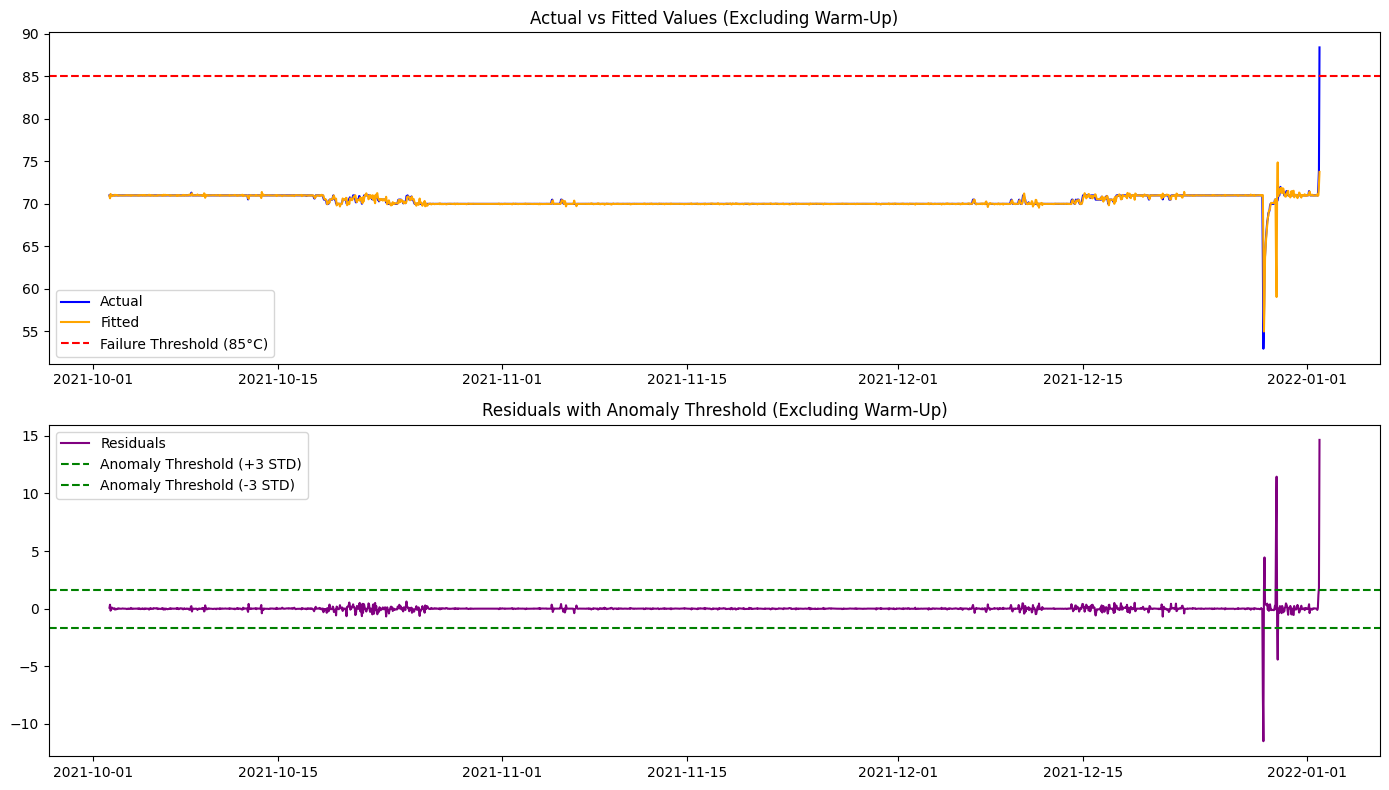


Average Contribution to Fitted Values:
MW_Contribution                  0.008793
WaterTemp_Contribution           0.052239
GrossHead(feet)_Contribution   -22.535688
dtype: float64


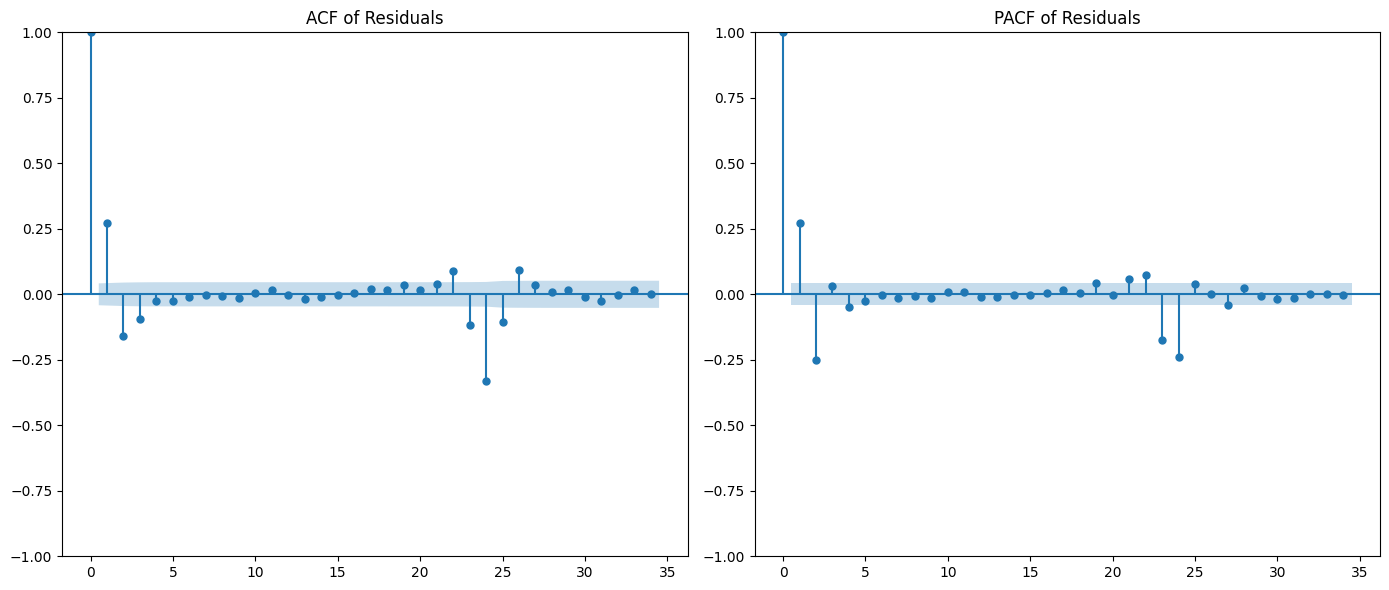

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set up working directory and file path
current_dir = os.getcwd()
file_path = os.path.join(current_dir, 'Averaged_Data.xlsx')

# Load the dataset
data = pd.read_excel(file_path)

# Ensure TimeStamp is in datetime format
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])
data.set_index('TimeStamp', inplace=True)

# Downsample the data to hourly averages, selecting only numeric columns
data = data.select_dtypes(include='number').resample('h').mean()

# Define the training period
train_start_date = '2021-10-01'
train_end_date = '2022-01-01'
train_data = data.loc[train_start_date:train_end_date].copy()  # Explicit copy to avoid warnings

# Define and fit the SARIMAX model
sarimax_model = SARIMAX(
    train_data['Avg_Temperature'],
    exog=train_data[['MW', 'WaterTemp', 'GrossHead(feet)']],
    order=(1, 0, 0),  # Simplified ARIMA parameters
    seasonal_order=(0, 1, 0, 24)  # Simplified seasonal parameters for daily seasonality.
)
sarimax_fit = sarimax_model.fit(disp=False)

# Calculate fitted values and residuals with .loc to avoid SettingWithCopyWarning
train_data.loc[:, 'Fitted_Values'] = sarimax_fit.fittedvalues
train_data.loc[:, 'Residuals'] = train_data['Avg_Temperature'] - train_data['Fitted_Values']

# Exclude the first 30 observations for warm-up
warm_up_period = 30
train_data = train_data.iloc[warm_up_period:]

# Calculate MAPE and RMSE
mape = np.mean(np.abs(train_data['Residuals'] / train_data['Avg_Temperature'])) * 100
rmse = np.sqrt(np.mean(train_data['Residuals'] ** 2))

print(f"MAPE (excluding first 30 observations): {mape:.2f}%")
print(f"RMSE (excluding first 30 observations): {rmse:.2f}")

# Analyze the impact of exogenous variables
try:
    coefficients = sarimax_fit.params[['MW', 'WaterTemp', 'GrossHead(feet)']]
    print("\nImpact of Exogenous Variables on Fitted Values:")
    print(coefficients)
except KeyError as e:
    print(f"Error: Could not find exogenous variables in the model parameters: {e}")
    print("Available parameters:", sarimax_fit.params.keys())
    coefficients = pd.Series(0, index=['MW', 'WaterTemp', 'GrossHead(feet)'])  # Default to 0

# Contribution of each exogenous variable
for var in ['MW', 'WaterTemp', 'GrossHead(feet)']:
    train_data.loc[:, f'{var}_Contribution'] = coefficients[var] * train_data[var]

# Extract auto-regressive coefficient for Avg_Temperature
try:
    ar_coefficient = sarimax_fit.params['ar.L1']
    print(f"\nAuto-Regressive Impact of Bearing Temperature on Itself: {ar_coefficient:.4f}")
except KeyError:
    print("\nAuto-Regressive Impact not found in the model parameters.")

# Plot Actual, Fitted, and Residuals (excluding warm-up)
plt.figure(figsize=(14, 8))

# Plot Actual vs Fitted
plt.subplot(2, 1, 1)
plt.plot(train_data.index, train_data['Avg_Temperature'], label='Actual', color='blue')
plt.plot(train_data.index, train_data['Fitted_Values'], label='Fitted', color='orange')
plt.axhline(y=85, color='red', linestyle='--', label='Failure Threshold (85°C)')
plt.legend()
plt.title('Actual vs Fitted Values (Excluding Warm-Up)')

# Plot Residuals
plt.subplot(2, 1, 2)
plt.plot(train_data.index, train_data['Residuals'], label='Residuals', color='purple')
plt.axhline(y=3 * train_data['Residuals'].std(), color='green', linestyle='--', label='Anomaly Threshold (+3 STD)')
plt.axhline(y=-3 * train_data['Residuals'].std(), color='green', linestyle='--', label='Anomaly Threshold (-3 STD)')
plt.legend()
plt.title('Residuals with Anomaly Threshold (Excluding Warm-Up)')

plt.tight_layout()
plt.show()

# Print contributions summary
contribution_summary = train_data[['MW_Contribution', 'WaterTemp_Contribution', 'GrossHead(feet)_Contribution']].mean()
print("\nAverage Contribution to Fitted Values:")
print(contribution_summary)

# Plot ACF and PACF for Residuals
plt.figure(figsize=(14, 6))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(train_data['Residuals'], ax=plt.gca(), title="ACF of Residuals")

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(train_data['Residuals'], ax=plt.gca(), title="PACF of Residuals")

plt.tight_layout()
plt.show()


In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the CUSUM function
def cusum(data, target, threshold):
    """
    Cumulative Sum (CUSUM) Control Chart
    data: array-like, input data to analyze
    target: float, target mean of the data
    threshold: float, threshold for detecting anomalies
    Returns:
        pos_cusum: positive CUSUM values
        neg_cusum: negative CUSUM values
        anomalies: indices of detected anomalies
    """
    pos_cusum = np.maximum.accumulate(data.cumsum() - target - threshold)
    neg_cusum = np.maximum.accumulate(-data.cumsum() + target - threshold)
    anomalies = np.where((pos_cusum > threshold) | (neg_cusum > threshold))[0]
    return pos_cusum, neg_cusum, anomalies

# Set up working directory and file path
current_dir = os.getcwd()
file_path = os.path.join(current_dir, 'Averaged_Data.xlsx')

# Load the dataset
data = pd.read_excel(file_path)

# Ensure TimeStamp is in datetime format
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])
data.set_index('TimeStamp', inplace=True)

# Downsample the data to hourly averages, selecting only numeric columns
data = data.select_dtypes(include='number').resample('h').mean()

# Define the training period
train_start_date = '2021-10-01'
train_end_date = '2022-01-01'
train_data = data.loc[train_start_date:train_end_date].copy()  # Explicit copy to avoid warnings

# Define and fit the SARIMAX model
sarimax_model = SARIMAX(
    train_data['Avg_Temperature'],
    exog=train_data[['MW', 'WaterTemp', 'GrossHead(feet)']],
    order=(1, 0, 0),  # Simplified ARIMA parameters
    seasonal_order=(0, 1, 0, 24)  # Simplified seasonal parameters for daily seasonality
)
sarimax_fit = sarimax_model.fit(disp=False)

# Calculate fitted values and residuals with .loc to avoid SettingWithCopyWarning
train_data.loc[:, 'Fitted_Values'] = sarimax_fit.fittedvalues
train_data.loc[:, 'Residuals'] = train_data['Avg_Temperature'] - train_data['Fitted_Values']

# Exclude the first 30 observations for warm-up
warm_up_period = 30
train_data = train_data.iloc[warm_up_period:]

# Calculate MAPE and RMSE
mape = np.mean(np.abs(train_data['Residuals'] / train_data['Avg_Temperature'])) * 100
rmse = np.sqrt(np.mean(train_data['Residuals'] ** 2))

print(f"MAPE (excluding first 30 observations): {mape:.2f}%")
print(f"RMSE (excluding first 30 observations): {rmse:.2f}")

# Analyze the impact of exogenous variables
try:
    coefficients = sarimax_fit.params[['MW', 'WaterTemp', 'GrossHead(feet)']]
    print("\nImpact of Exogenous Variables on Fitted Values:")
    print(coefficients)
except KeyError as e:
    print(f"Error: Could not find exogenous variables in the model parameters: {e}")
    print("Available parameters:", sarimax_fit.params.keys())
    coefficients = pd.Series(0, index=['MW', 'WaterTemp', 'GrossHead(feet)'])  # Default to 0

# Contribution of each exogenous variable
for var in ['MW', 'WaterTemp', 'GrossHead(feet)']:
    train_data.loc[:, f'{var}_Contribution'] = coefficients[var] * train_data[var]

# Extract auto-regressive coefficient for Avg_Temperature
try:
    ar_coefficient = sarimax_fit.params['ar.L1']
    print(f"\nAuto-Regressive Impact of Bearing Temperature on Itself: {ar_coefficient:.4f}")
except KeyError:
    print("\nAuto-Regressive Impact not found in the model parameters.")

# Perform CUSUM analysis on residuals
residuals = train_data['Residuals'].values  # Residuals from SARIMAX
target = 0  # Target mean for residuals
threshold = 3 * residuals.std()  # Threshold based on standard deviation

# Apply CUSUM
pos_cusum, neg_cusum, anomalies = cusum(residuals, target, threshold)



MAPE (excluding first 30 observations): 0.12%
RMSE (excluding first 30 observations): 0.55

Impact of Exogenous Variables on Fitted Values:
MW                 0.000140
WaterTemp          0.004045
GrossHead(feet)   -0.089950
dtype: float64

Auto-Regressive Impact of Bearing Temperature on Itself: 0.8833


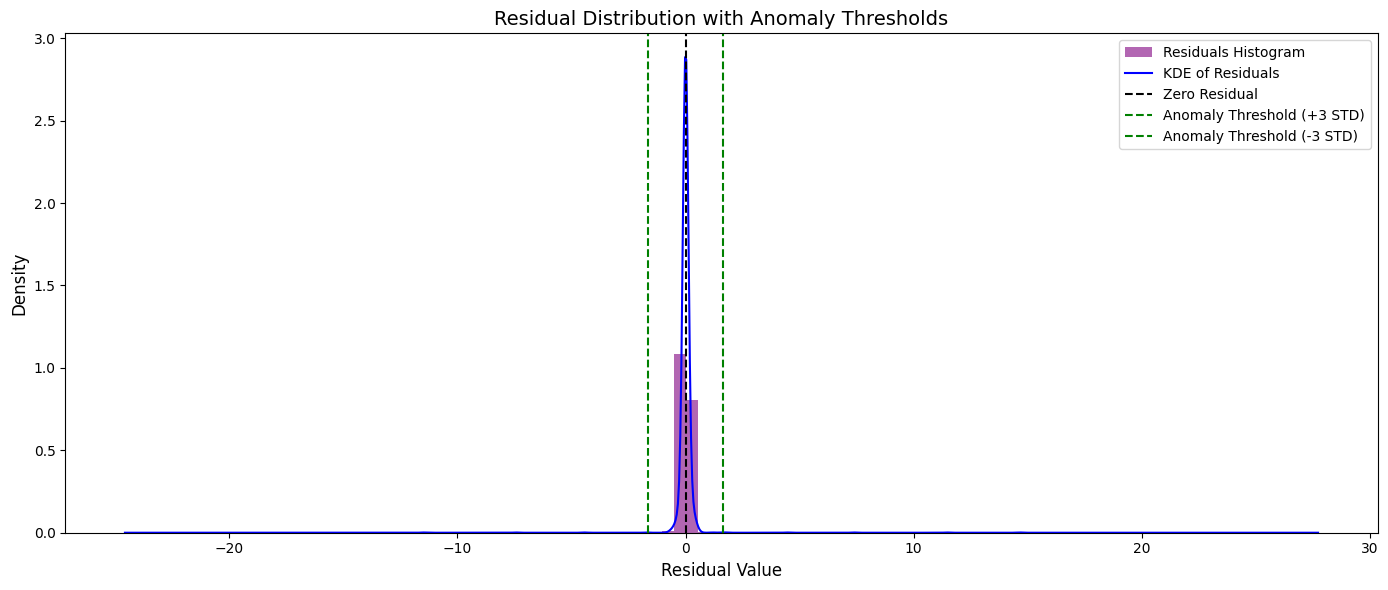

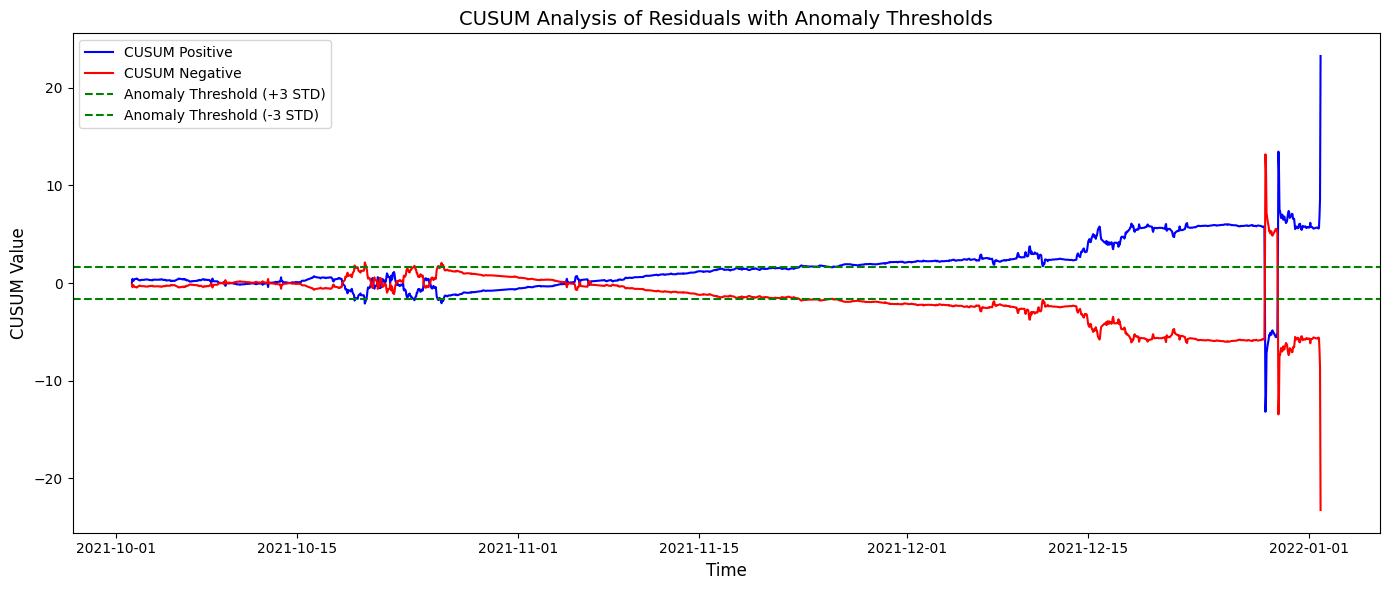

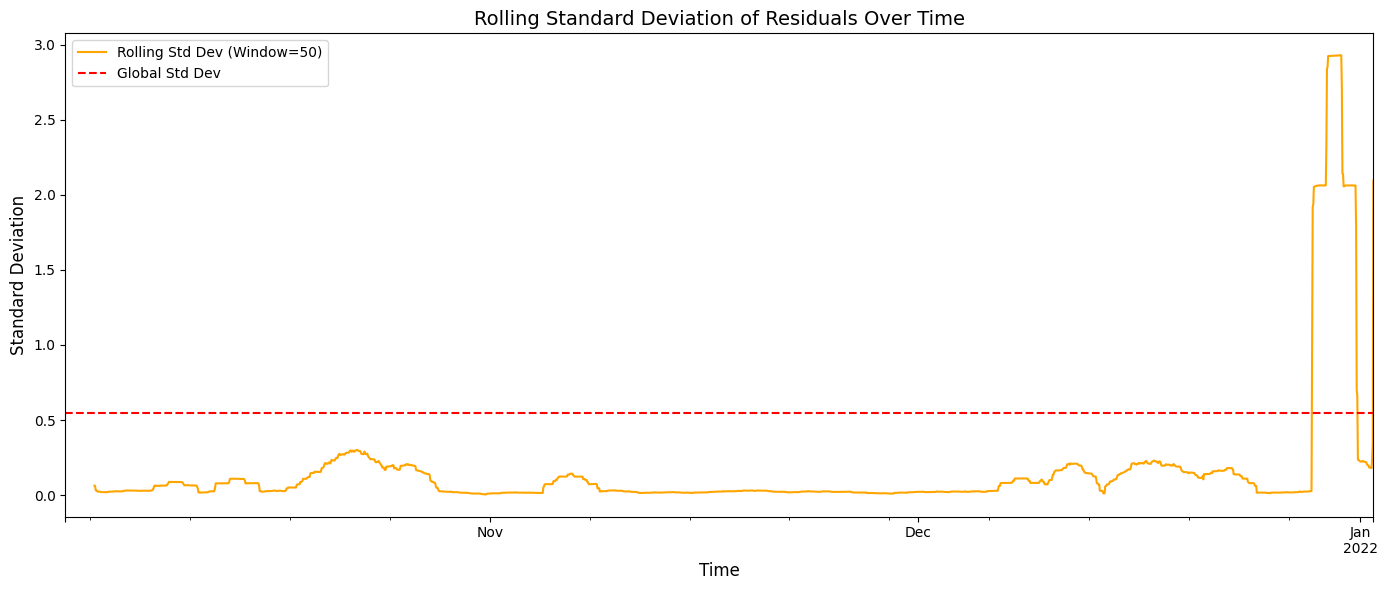

In [20]:
# Residual Distribution Analysis
plt.figure(figsize=(14, 6))
train_data['Residuals'].plot(kind='hist', bins=50, alpha=0.6, density=True, color='purple', label='Residuals Histogram')
train_data['Residuals'].plot(kind='kde', color='blue', label='KDE of Residuals')
plt.axvline(0, color='black', linestyle='--', label='Zero Residual')
plt.axvline(3 * train_data['Residuals'].std(), color='green', linestyle='--', label='Anomaly Threshold (+3 STD)')
plt.axvline(-3 * train_data['Residuals'].std(), color='green', linestyle='--', label='Anomaly Threshold (-3 STD)')
plt.title('Residual Distribution with Anomaly Thresholds', fontsize=14)
plt.xlabel('Residual Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


# Residual Analysis with CUSUM
threshold = 3 * train_data['Residuals'].std()
cusum_positive = train_data['Residuals'].cumsum()
cusum_negative = -train_data['Residuals'].cumsum()

plt.figure(figsize=(14, 6))
plt.plot(train_data.index, cusum_positive, label='CUSUM Positive', color='blue')
plt.plot(train_data.index, cusum_negative, label='CUSUM Negative', color='red')
plt.axhline(threshold, color='green', linestyle='--', label='Anomaly Threshold (+3 STD)')
plt.axhline(-threshold, color='green', linestyle='--', label='Anomaly Threshold (-3 STD)')
plt.title('CUSUM Analysis of Residuals with Anomaly Thresholds', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('CUSUM Value', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


# Rolling Standard Deviation
plt.figure(figsize=(14, 6))
train_data['Residuals'].rolling(window=50).std().plot(label='Rolling Std Dev (Window=50)', color='orange')
plt.axhline(train_data['Residuals'].std(), color='red', linestyle='--', label='Global Std Dev')
plt.title('Rolling Standard Deviation of Residuals Over Time', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Standard Deviation', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


C:\Users\abw26\AppData\Local\Temp\ipykernel_1552\71898774.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(train_data.index[anomalies], cusum_positive[anomalies], color='purple', label='Anomalies')
C:\Users\abw26\AppData\Local\Temp\ipykernel_1552\71898774.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate('Failure Event', xy=(failure_event, cusum_positive[-1]), xytext=(failure_event, cusum_positive[-1] + 5),


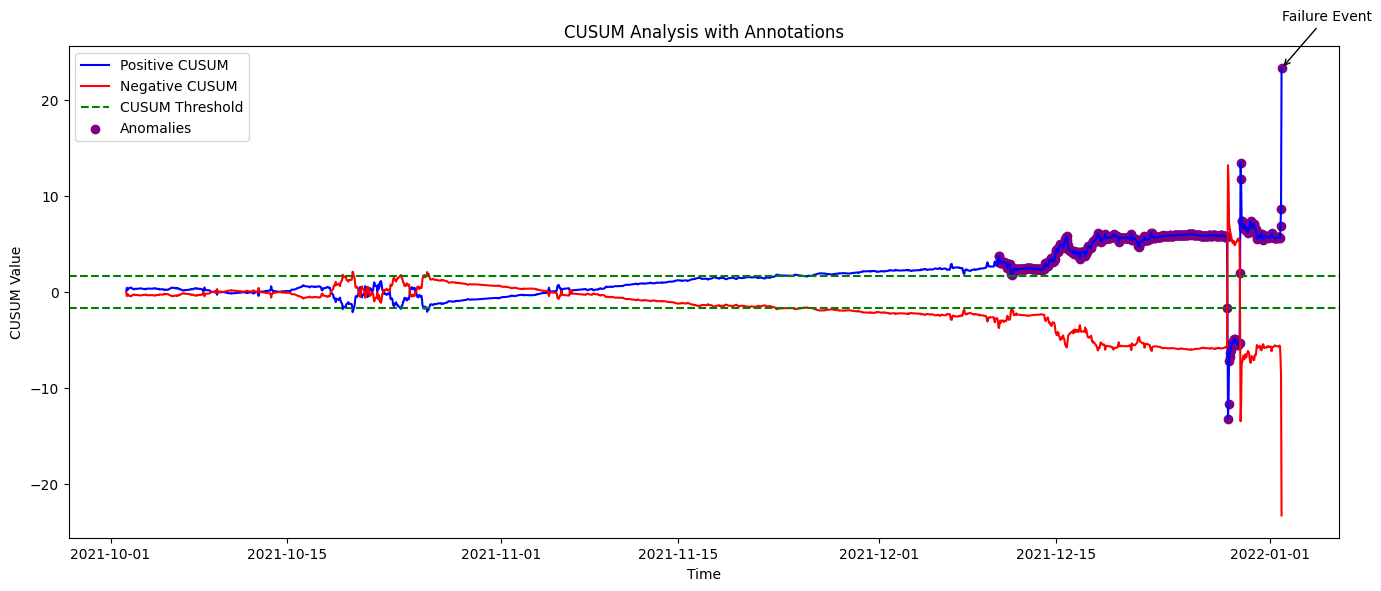

In [ ]:
plt.figure(figsize=(14, 6))

# Plot CUSUM values
plt.plot(train_data.index, cusum_positive, label='Positive CUSUM', color='blue')
plt.plot(train_data.index, cusum_negative, label='Negative CUSUM', color='red')

# Add anomaly thresholds
plt.axhline(threshold, color='green', linestyle='--', label='CUSUM Threshold')
plt.axhline(-threshold, color='green', linestyle='--')

# Highlight anomalies
plt.scatter(train_data.index[anomalies], cusum_positive[anomalies], color='purple', label='Anomalies')

# Annotate failure event
failure_event = train_data.index[-1] 
plt.annotate('Failure Event', xy=(failure_event, cusum_positive[-1]), xytext=(failure_event, cusum_positive[-1] + 5),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

plt.title('CUSUM Analysis with Annotations')
plt.xlabel('Time')
plt.ylabel('CUSUM Value')
plt.legend()
plt.tight_layout()
plt.show()
